In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,RobustScaler,PowerTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,f1_score,classification_report,roc_curve, roc_auc_score
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier,VotingClassifier,StackingClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,chi2,f_classif
import pickle as pkl

In [3]:
df=pd.read_csv('/content/Bank churn.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Exited']=[0 if i<0.5 else 1 for i in df['Exited']]

In [4]:
df.head()

CreditScore Geography Gender   Age  Tenure    Balance  NumOfProducts  \
0        668.0    France   Male  33.0     3.0       0.00            2.0   
1        627.0    France   Male  33.0     1.0       0.00            2.0   
2        678.0    France   Male  40.0    10.0       0.00            2.0   
3        588.0   Germany   Male  36.0     4.0  131778.58            1.0   
4        678.0     Spain   Male  37.0     1.0  138476.41            1.0   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0        1.0             0.0        181449.97       0  
1        1.0             1.0         49503.50       0  
2        1.0             0.0        184866.69       0  
3        1.0             0.0        136024.31       1  
4        1.0             0.0        106851.60       0

# Null Checking

In [5]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# Duplicates Checking

In [6]:
df.duplicated().sum()

31

In [7]:
#drop dublicates
df.drop_duplicates(inplace=True)

In [8]:
def column_info(data):
    cols=[]
    col_uniques=[]
    col_numberofuniques=[]
    dtype=[]
    for col in data.columns:
        cols.append(col)
        dtype.append(data[col].dtype.name)
        col_uniques.append(data[col].unique())
        col_numberofuniques.append(data[col].nunique())
    return pd.DataFrame({'name':cols,'data type':dtype,'unique_Values':col_uniques,'no_unique':col_numberofuniques})

In [9]:
column_info(df)

name data type  \
0       CreditScore   float64   
1         Geography    object   
2            Gender    object   
3               Age   float64   
4            Tenure   float64   
5           Balance   float64   
6     NumOfProducts   float64   
7         HasCrCard   float64   
8    IsActiveMember   float64   
9   EstimatedSalary   float64   
10           Exited     int64   

                                        unique_Values  no_unique  
0   [668.0, 627.0, 678.0, 588.0, 676.0, 681.0, 602...        262  
1                            [France, Germany, Spain]          3  
2                                      [Male, Female]          2  
3   [33.0, 40.0, 36.0, 37.0, 43.0, 47.0, 35.0, 41....         39  
4   [3.0, 1.0, 10.0, 4.0, 5.0, 7.0, 9.0, 8.0, 0.0,...         11  
5   [0.0, 131778.58, 138476.41, 117559.05, 136789....      18375  
6                                [2.0, 1.0, 3.0, 4.0]          4  
7                                          [1.0, 0.0]          2  
8                                          [0.0, 1.0]          2  
9   [181449.97, 49503.5, 184866.69, 136024.31, 106...      49594  
10                                             [0, 1]          2

# Outliers Checking

In [10]:
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
fig = make_subplots(rows=2, cols=2, subplot_titles=num_cols)
for i, col in enumerate(num_cols, start=1):
    row_num = 1 if i <= 2 else 2
    col_num = i if i <= 2 else i - 2
    fig.add_trace(
        go.Box(
            x=df[col],
            name=col,
            marker_color='#26090b',
            line_color='#26090b'
        ),
        row=row_num,
        col=col_num
    )
fig.update_layout(
    title_text="Horizontal Boxplots of Numerical Columns",
    showlegend=False,
    plot_bgcolor="#764a23",
    paper_bgcolor="#E8CE9D"
)
fig.show()

**Encoding**

In [11]:
df['Gender']=[1 if i =='Male' else 0 for i in df['Gender']]

In [12]:
encoder = OrdinalEncoder(categories=[['Spain','Germany','France']],dtype=int)
df['Geography']=encoder.fit_transform(df[['Geography']])

# Correlation

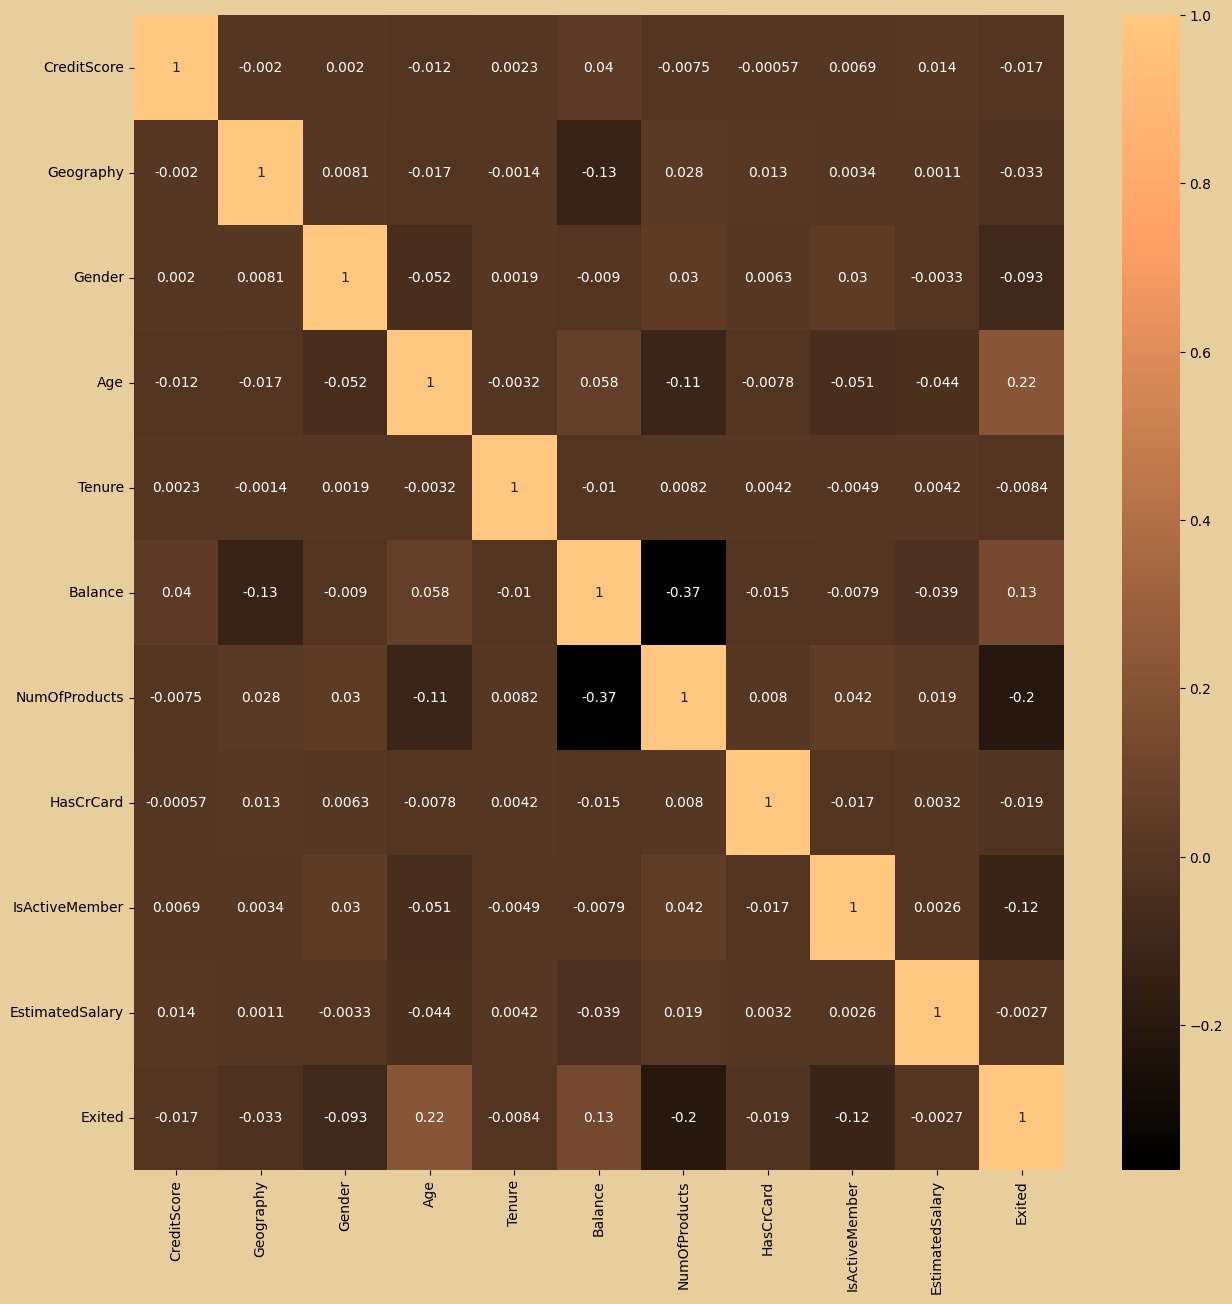

In [13]:
fig = plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True,cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

# Unbalance Checking

<ipython-input-14-bfd74a96a50d>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




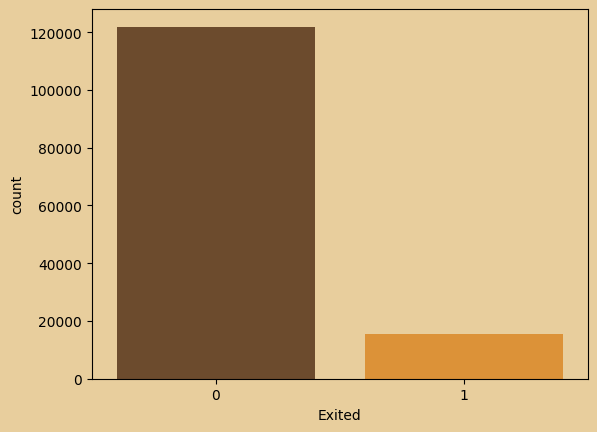

In [14]:
fig, ax = plt.subplots()
sns.countplot(data=df, x='Exited', ax=ax, palette=["#764a23","#f7941d"])
fig.patch.set_facecolor("#E8CE9D")
ax.set_facecolor("#E8CE9D")
plt.show()

# Data Spliting

In [15]:
x=df.drop(['Exited'],axis=1)
y=df['Exited']

In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,random_state=42,test_size=0.2)

# Unbalance Handling

In [17]:
smote=SMOTE(random_state=42)
x_train,y_train=smote.fit_resample(x_train,y_train)

# Data Scaling

In [18]:
pt = PowerTransformer(method='yeo-johnson')
x_train = pt.fit_transform(x_train)
x_test = pt.transform(x_test)
x_valid= pt.transform(x_valid)

In [19]:
scaler=RobustScaler()
x_train=scaler.fit_transform(x_train)
x_valid=scaler.transform(x_valid)
x_test=scaler.transform(x_test)

# Function For Check OverFitting

In [20]:
def check_overfitting(model,x_train,y_train,x_vald,y_vald):
        y_tr_pred=model.predict(x_train)
        train_accuracy=accuracy_score(y_train,y_tr_pred)
        y_val_pred=model.predict(x_vald)
        valid_accuracy=accuracy_score(y_vald,y_val_pred)
        print("Model Metrics for CheckingOverfitting")
        print(f"Accuracy_ train {train_accuracy}")
        print(f"Accuracy_ validation {valid_accuracy}")

# Logistic Regression

In [ ]:
logistic=LogisticRegression()
logistic.fit(x_train,y_train)

LogisticRegression()

In [ ]:
check_overfitting(logistic,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.7599384654829818
Accuracy_ validation 0.7397397397397397


In [ ]:
y_pred=logistic.predict(x_test)

In [ ]:
logistc_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
logistc_accuracy

0.7358401281304601

In [ ]:
confusion_matrix(y_test,y_pred)

array([[18256,  6133],
       [ 1124,  1959]])

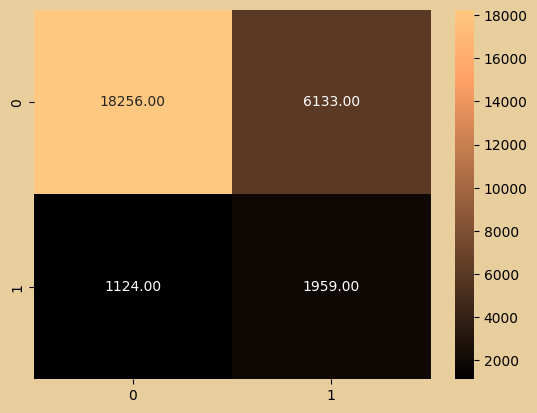

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(logistic,open('logistic.pkl',"wb"))

# KNN

In [ ]:
params={
    'n_neighbors':[3,5,7,9,11],
    'p':[1,2]
}
knn=KNeighborsClassifier()

grid=GridSearchCV(
    estimator=knn,
    param_grid=params,
    scoring='accuracy',
    cv=5
)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2]},
             scoring='accuracy')

In [ ]:
knn_model=grid.best_estimator_

In [ ]:
check_overfitting(knn_model,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.9414845202230626
Accuracy_ validation 0.8218218218218218


In [ ]:
# use cross validation because there is over fitting
kfold_cross=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scores=cross_val_score(knn_model,x_train,y_train,cv=kfold_cross)
scores.mean()

0.8695916928402024

In [ ]:
y_pred=knn_model.predict(x_test)
knn_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
knn_accuracy

0.8224737914967968

In [ ]:
confusion_matrix(y_test,y_pred)

array([[21308,  3081],
       [ 1796,  1287]])

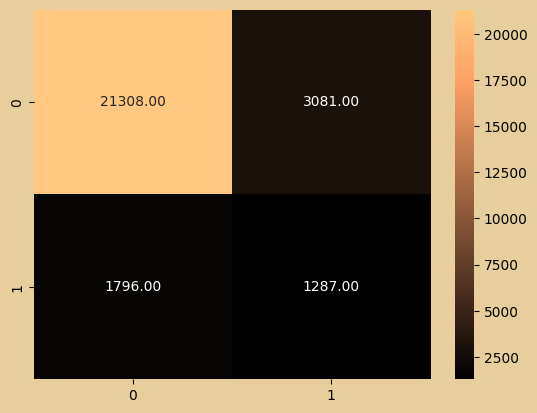

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(knn_model,open('knn.pkl',"wb"))

# Decision Tree

In [ ]:
params={'criterion':['entropy','gini'],
    'max_depth':[3,4,5,6,7,8,9,10],
    'ccp_alpha':[.001,.002,.003,.004]}
tree=DecisionTreeClassifier()
grid=GridSearchCV(estimator=tree,param_grid=params,cv=5,scoring='accuracy')
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.001, 0.002, 0.003, 0.004],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [ ]:
decision_model=grid.best_estimator_
check_overfitting(decision_model,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.8814499070572399
Accuracy_ validation 0.8601328601328602


In [ ]:
y_pred=decision_model.predict(x_test)
tree_accuracy=accuracy_score(y_test,y_pred)
tree_accuracy

0.8559260337798485

In [ ]:
confusion_matrix(y_test,y_pred)

array([[22089,  2300],
       [ 1658,  1425]])

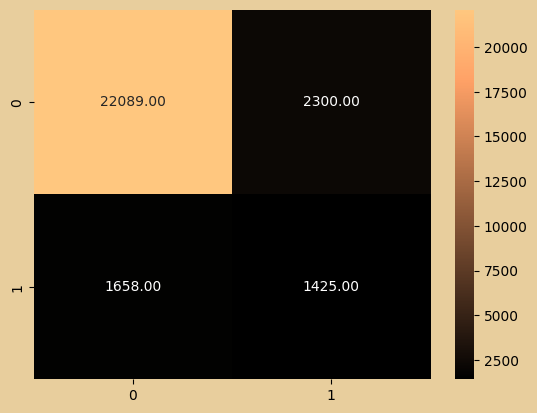

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(decision_model,open('decision_tree.pkl',"wb"))

# Naive Bayes

In [ ]:
classsifier=GaussianNB()
classsifier.fit(x_train,y_train)

GaussianNB()

In [ ]:
check_overfitting(classsifier,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.7687904621498622
Accuracy_ validation 0.7512967512967513


In [ ]:
y_pred=classsifier.predict(x_test)
naive_accuracy=accuracy_score(y_test,y_pred)
naive_accuracy

0.7460323238206173

In [ ]:
confusion_matrix(y_test,y_pred)

array([[18599,  5790],
       [ 1187,  1896]])

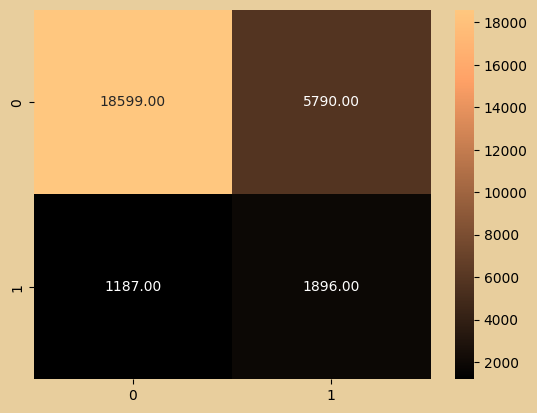

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(classsifier,open('naive_bayes.pkl',"wb"))

# SVM

In [ ]:
svm=SVC(C=1, gamma='scale',kernel='rbf')
svm.fit(x_train,y_train)
check_overfitting(svm,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.8574065765015063
Accuracy_ validation 0.8426608426608426


In [ ]:
y_pred=svm.predict(x_test)
svm_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
svm_accuracy

0.8366336633663366

In [ ]:
confusion_matrix(y_test,y_pred)

array([[21484,  2905],
       [ 1583,  1500]])

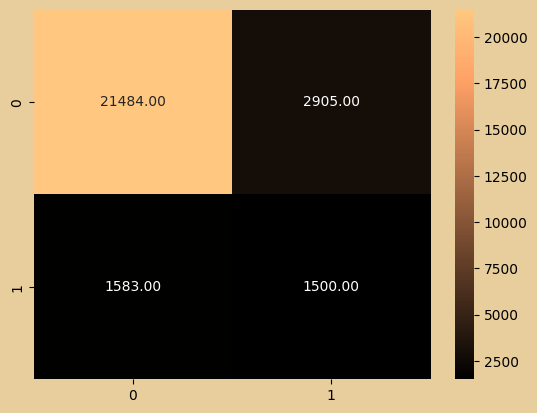

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(svm,open('svm.pkl',"wb"))

# Random Forest

In [ ]:
params = {
    'n_estimators':[50, 100, 200],
    'max_depth':[10, 20]
}
rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid =  params,scoring='accuracy',cv=5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20], 'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
random_model=grid.best_estimator_
check_overfitting(random_model,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.9797256586116274
Accuracy_ validation 0.8795613795613796


In [ ]:
# use cross validation because there is over fitting
kfold_cross=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scores=cross_val_score(random_model,x_train,y_train,cv=kfold_cross)
scores.mean()

0.9284404845843215

In [ ]:
y_pred=random_model.predict(x_test)
rand_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
rand_accuracy

0.8793680838672102

In [ ]:
print(confusion_matrix(y_test,y_pred))

[[23159  1230]
 [ 2084   999]]


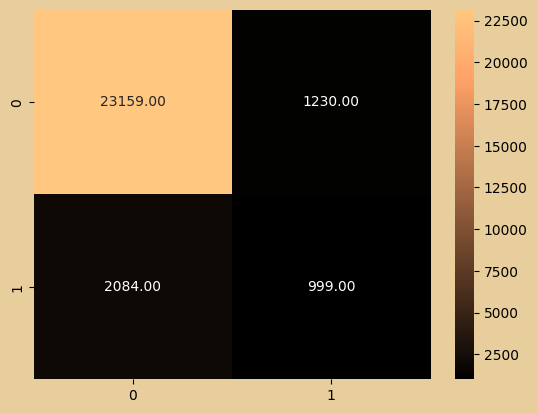

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(random_model,open('Random_forest.pkl',"wb"))

# Ada Boosting

In [ ]:
params = {
    "n_estimators":[50,100,200],
    "learning_rate":[.5,.05,.25],
    "random_state":[42]
}
ada = AdaBoostClassifier()
grid = GridSearchCV(ada, param_grid = params,scoring='accuracy',cv=5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.5, 0.05, 0.25],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring='accuracy')

In [ ]:
ada_model=grid.best_estimator_
check_overfitting(ada_model,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.9070444202294725
Accuracy_ validation 0.8677313677313677


In [ ]:
y_pred=ada_model.predict(x_test)
ada_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
ada_accuracy

0.8659726266744322

In [ ]:
confusion_matrix(y_test,y_pred)

array([[22458,  1931],
       [ 1751,  1332]])

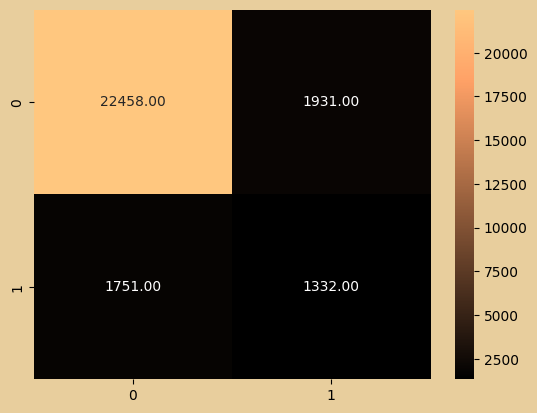

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(ada_model,open('Ada.pkl',"wb"))

# Gradient Boosting

In [ ]:
params = {
    "n_estimators":[50,100,200],
    "learning_rate":[.5,.05,.25,.1],
    'random_state':[42]
}
grad = GradientBoostingClassifier()
grid = GridSearchCV(grad, param_grid = params,scoring='accuracy',cv=5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.5, 0.05, 0.25, 0.1],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring='accuracy')

In [ ]:
grad=grid.best_estimator_
check_overfitting(grad,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.941984488173835
Accuracy_ validation 0.8911638911638912


In [ ]:
y_pred=grad.predict(x_test)
grad_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
grad_accuracy

0.8892326732673267

In [ ]:
confusion_matrix(y_test,y_pred)

array([[23777,   612],
       [ 2431,   652]])

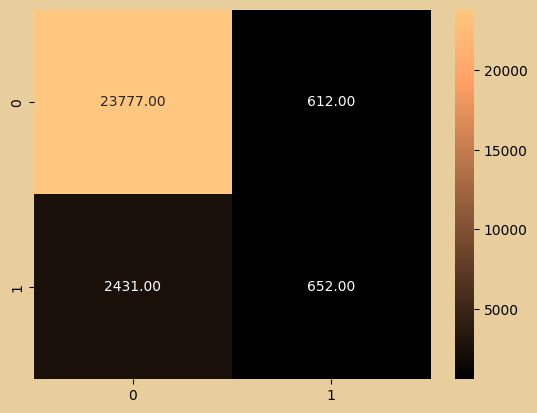

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(grad,open('Gradient.pkl',"wb"))

# XG Boosting

In [ ]:
params = {
    "n_estimators":[50,100,200],
    "learning_rate":[.5,.05,.25,.1],
    'random_state':[42]
}
xg = xgb.XGBClassifier()
grid = GridSearchCV(xg, param_grid = params,scoring='accuracy',cv=5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.5, 0.05, 0.25, 0.1],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring='accuracy')

In [ ]:
xg_model=grid.best_estimator_
check_overfitting(xg_model,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.9505608614832383
Accuracy_ validation 0.8911638911638912


In [ ]:
# use cross validation because there is over fitting
kfold_cross=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scores=cross_val_score(xg_model,x_train,y_train,cv=kfold_cross)
scores.mean()

0.935831036472021

In [ ]:
y_pred=xg_model.predict(x_test)
xg_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
xg_accuracy

0.8888322655794991

In [ ]:
confusion_matrix(y_test,y_pred)

array([[23718,   671],
       [ 2383,   700]])

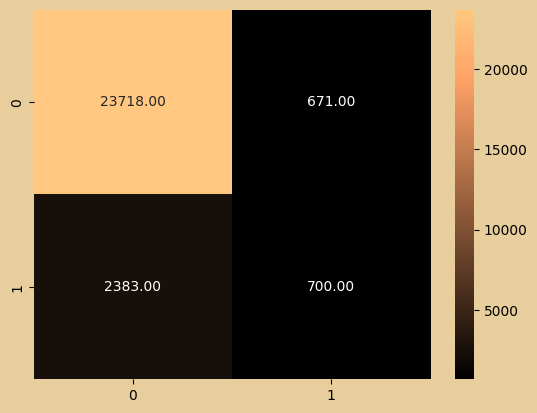

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(xg_model,open('XG.pkl',"wb"))

# Bagging on different

In [ ]:
estimators = [('logistic', LogisticRegression()), ('Decision Tree', DecisionTreeClassifier())]
voting = VotingClassifier(estimators=estimators)

In [ ]:
bagging_different = BaggingClassifier(base_estimator=voting,n_estimators=100,random_state=42)
bagging_different.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



BaggingClassifier(base_estimator=VotingClassifier(estimators=[('logistic',
                                                               LogisticRegression()),
                                                              ('Decision Tree',
                                                               DecisionTreeClassifier())]),
                  n_estimators=100, random_state=42)

In [ ]:
check_overfitting(bagging_different,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.8846420101275559
Accuracy_ validation 0.8836563836563837


In [ ]:
y_pred=bagging_different.predict(x_test)
bagging_different_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
bagging_different_accuracy

0.8798776936517181

In [ ]:
confusion_matrix(y_test,y_pred)

array([[23560,   829],
       [ 2471,   612]])

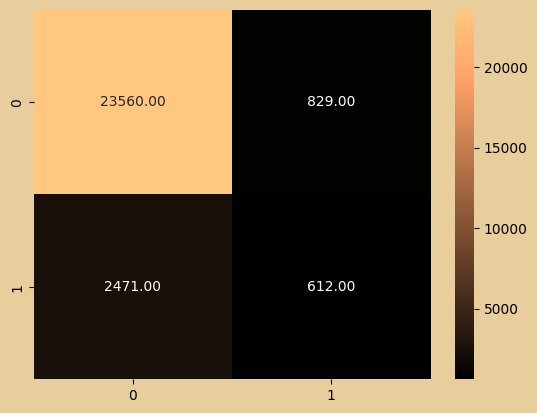

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(bagging_different,open('bagging_different.pkl',"wb"))

# Stacking

In [ ]:
estimators= [('Random', RandomForestClassifier()), ('Decision Tree', DecisionTreeClassifier())]
stacking=StackingClassifier(estimators=estimators,final_estimator=LogisticRegression())
stacking.fit(x_train,y_train)
check_overfitting(stacking,x_train,y_train,x_valid,y_valid)

Model Metrics for CheckingOverfitting
Accuracy_ train 0.9999038523171592
Accuracy_ validation 0.8763763763763763


In [ ]:
# use cross validation because there is over fitting
kfold_cross=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scores=cross_val_score(stacking,x_train,y_train,cv=kfold_cross)
scores.mean()

0.9289340426895712

In [ ]:
y_pred=stacking.predict(x_test)
stacking_accuracy=accuracy_score(y_test,y_pred)

In [ ]:
stacking_accuracy

0.8737259755387303

In [ ]:
confusion_matrix(y_test,y_pred)

array([[22954,  1435],
       [ 2034,  1049]])

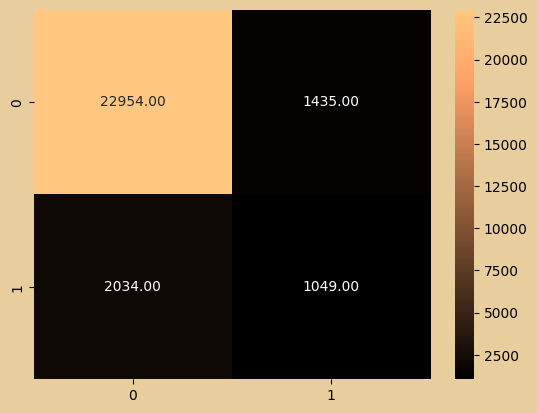

In [ ]:
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='copper')
fig.patch.set_facecolor('#E8CE9D')
ax = plt.gca()
ax.set_facecolor('#764a23')
plt.show()

In [ ]:
pkl.dump(stacking,open('stacking.pkl',"wb"))

# compare

<Axes: >

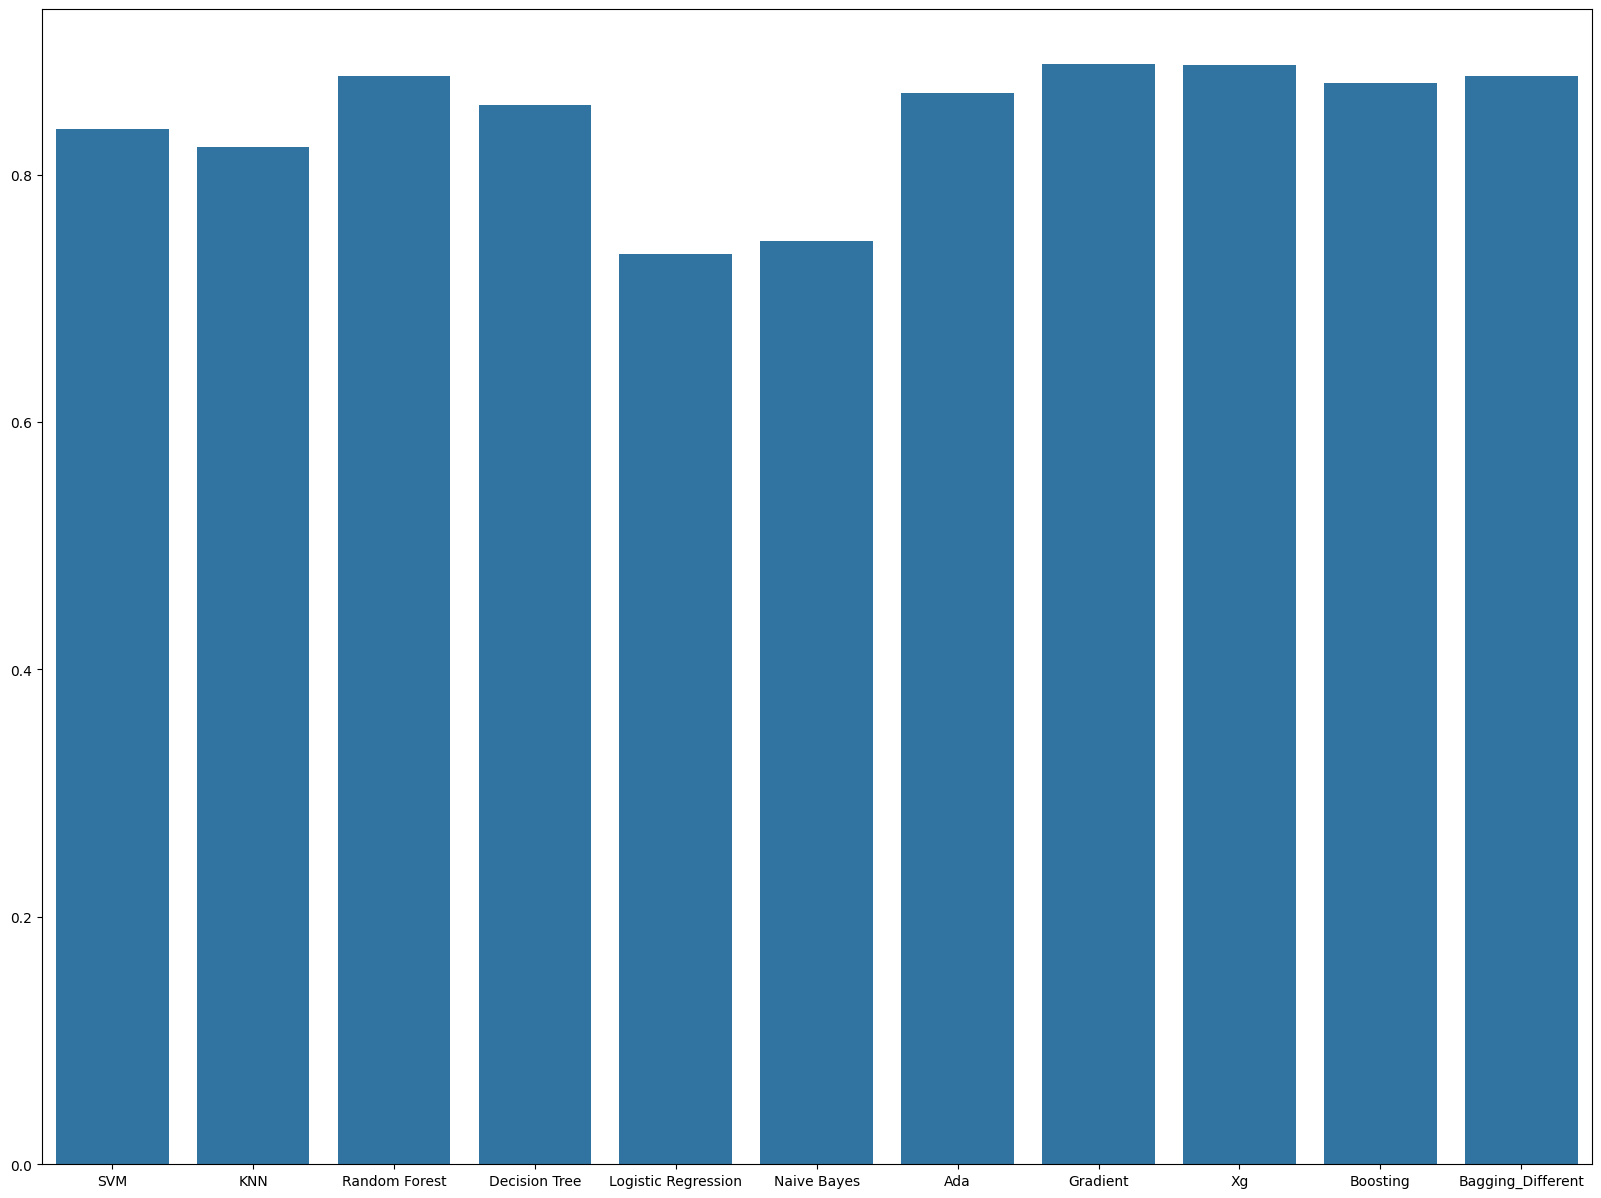

In [ ]:
plt.figure(figsize=(20,15))
metrics = ['SVM', 'KNN', 'Random Forest', 'Decision Tree', 'Logistic Regression','Naive Bayes','Ada','Gradient','Xg','stacking','Bagging_Different']
accuracy = [svm_accuracy,knn_accuracy, rand_accuracy,tree_accuracy,logistc_accuracy,naive_accuracy,ada_accuracy,grad_accuracy,xg_accuracy,stacking_accuracy,bagging_different_accuracy]
sns.barplot(x=metrics, y=accuracy)

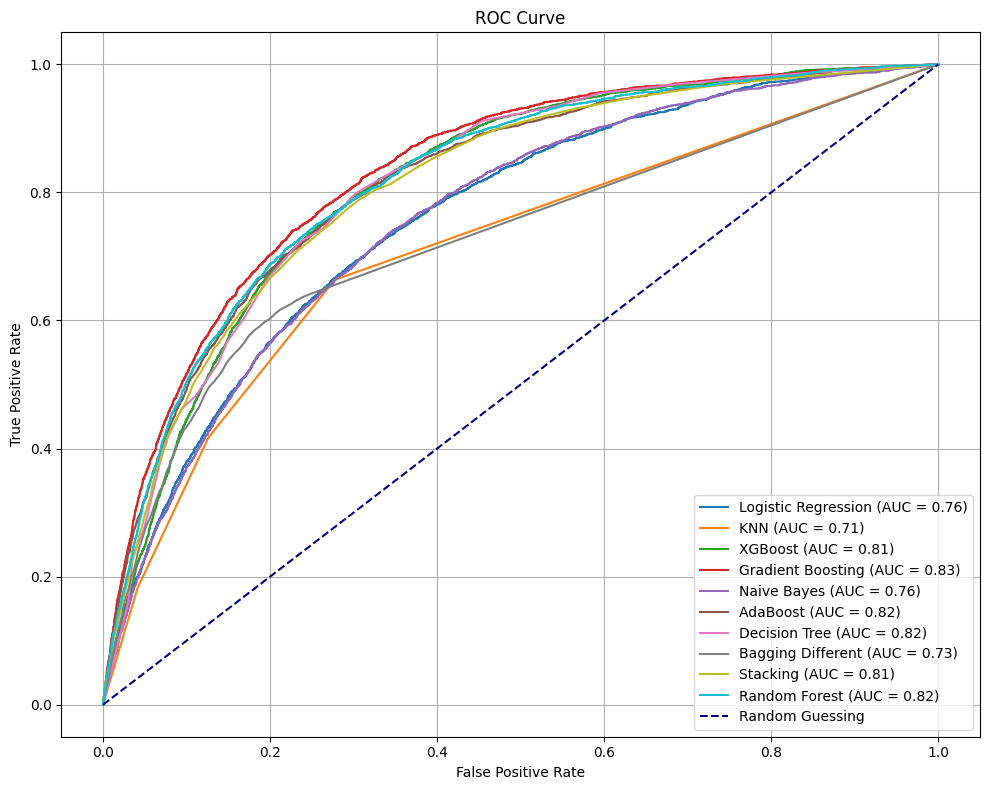

In [27]:
models = [
    ('Logistic Regression', pkl.load(open('/content/logistic.pkl','rb'))),
    ('KNN', pkl.load(open('/content/knn.pkl','rb'))),
    ('XGBoost', pkl.load(open('/content/XG.pkl','rb'))),
    ('Gradient Boosting', pkl.load(open('/content/Gradient.pkl','rb'))),
    ('Naive Bayes', pkl.load(open('/content/naive_bayes.pkl','rb'))),
    ('AdaBoost', pkl.load(open('/content/Ada.pkl','rb'))),
    ('Decision Tree', pkl.load(open('/content/decision_tree.pkl','rb'))),
    ('Bagging Different', pkl.load(open('/content/bagging_different.pkl','rb'))),
    ('Stacking', pkl.load(open('/content/stacking.pkl','rb'))),
    ('Random Forest', pkl.load(open('/content/Random_forest.pkl','rb')))
]

plt.figure(figsize=(10, 8))
for name, model in models:
    y_prob = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()